# Persistent homolgy for topological analysis of SMLM data


In this tutorial we demonstrate how to use the RSMLM and TDA packages for topological analysis of single molecule localization microscopy (SMLM) data through persistent homology. Lets start by loading these packages:


In [4]:
library(RSMLM)
library(TDA)

Now lets load some data to work with. This simulated dSTORM dataset consists of five rings, with radius 60nm. 

[1] "There are 743 detections in this dataset"


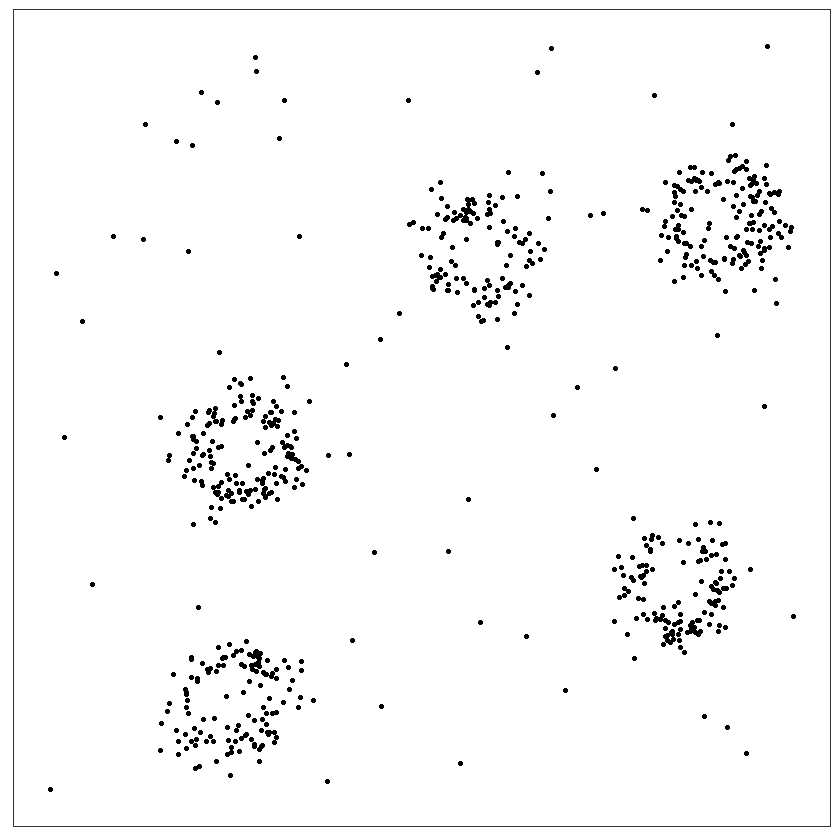

In [5]:
# load the csv file
coords <- as.matrix(read.csv("../data/detectionListRings.csv"))

numDetections <- dim(coords)[1]
print(paste('There are', numDetections, 'detections in this dataset'))

# plot the data
plotClusterScatter(coords, rep(0, numDetections))

### Clustering

Before performing a topological analysis we will segment the rings using persistence based clustering (ToMATo):

[1] "ToMATO found 5 clusters in the dataset."


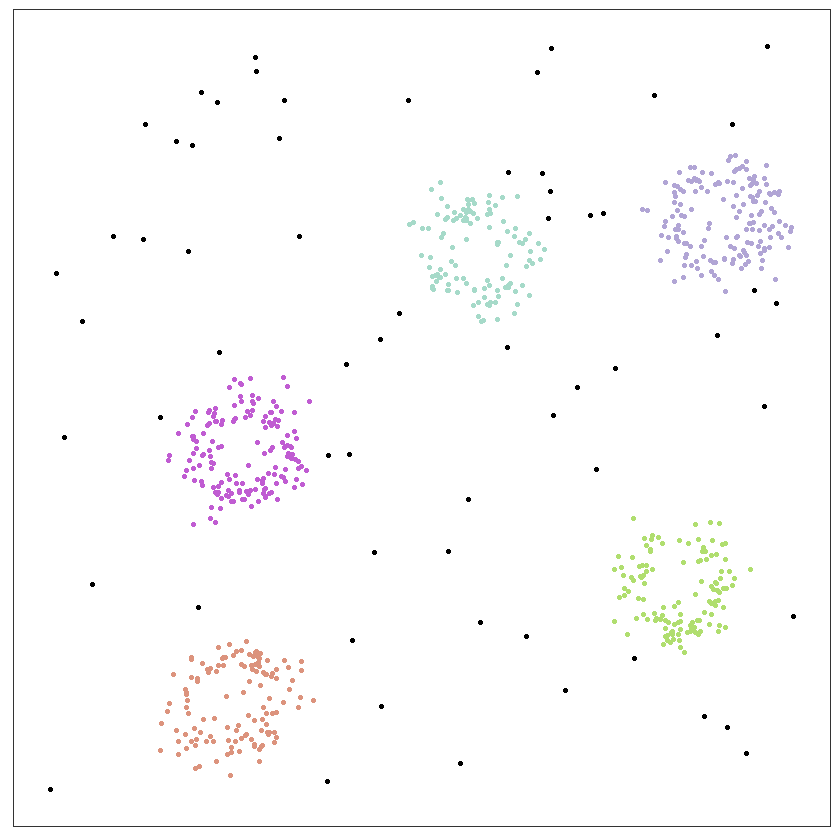

In [11]:
# search radius
tomatoR <- 30
# persistence threshold
tomatoThresh <- 20

# cluster data using ToMATo
clusterIndex <- clusterTomato(coords, tomatoR, tomatoThresh)

# number of clusters
numClusters <- sum(unique(clusterIndex) > 0)

print(paste('ToMATo found', numClusters, 'clusters in the dataset.'))

# plot the clustering result
plotClusterScatter(coords, clusterIndex)


## Persistent homology with TDA library

We will now use the TDA package to perform persistent homolgy for each cluster. We need to specify the maximum scale for the filtration and also the maximum dimension for which features are calculated. Dimension zero refers to connected components, one to holes and two to voids. 

This returns a persistence diagram for each cluster which contains the birth and death scales for all features in the filtration. We can then calculate the number of features, for each cluster, above a specified persistence threshold.

We also combine the persistence diagrams for all clusters. This combined diagram is plotted using the TDA package.


[1] "There are 5 holes above the persistence threshold and a mean of 1 hole per cluster"


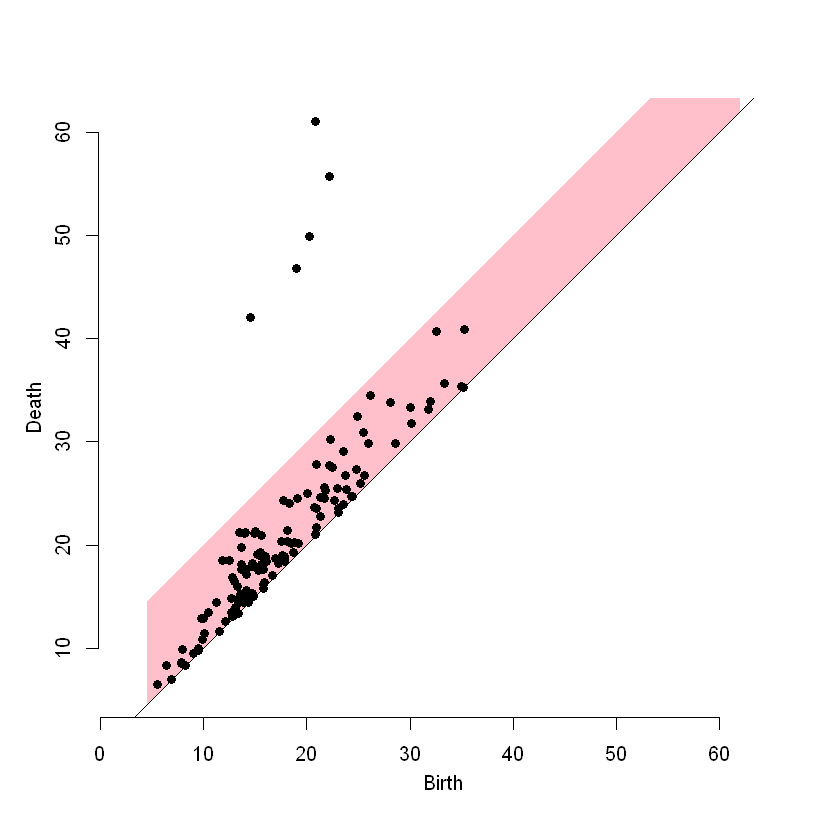

In [14]:
# upper limit for the filtration
maxScale <- 75 
# calculate connected components and holes
maxDimension <- 1 
# Persistence threshold for significant holes
persistenceThreshold <- 10;

# vector to hold the number of significant holes for each cluster
numHoles <- rep(0, numClusters)

for (i in 1 : numClusters) {
        
        # retrieve the cluster coordinates
        clusterCoords <- coords[clusterIndex == i, ]
        
        # calculate the persistence diagram using the TDA package
        diag <- ripsDiag(X = clusterCoords, maxDimension, maxScale, library = "GUDHI", printProgress = FALSE)$diagram 
        
        # find the number of holes with persistence above the threshold (using RSMLM)
        numHoles[i] <- findNumFeatures(diag, maxDimension, persistenceThreshold) 
        
        # add features to the combined diagram
        if (i == 1) {
            diagComb <- diag
        } else {
            diagComb <- rbind(diagComb, diag)
        }
    
        
       
}


totalNumberHoles <- sum(numHoles)
meanNumberHoles <- mean(numHoles)
print(paste('There are', totalNumberHoles, 'holes above the persistence threshold and a mean of',
            meanNumberHoles, 'hole per cluster'))

# plot the persistence diagram for first order features (holes) using TDA
plot.diagram(diagComb[diagComb[ , 'dimension'] == maxDimension, ],
             band = persistenceThreshold, asp=1, pch = 16, col = 'black')
